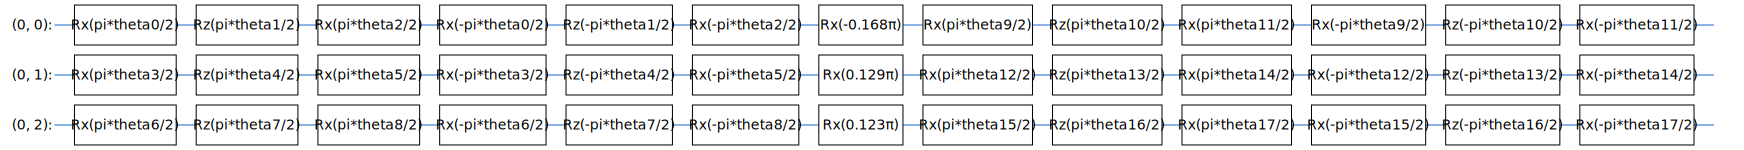

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sympy
import cirq

%matplotlib inline
from cirq.contrib.svg import SVGCircuit

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(r"D:\Modules_UCD\EEEN40690\Final project\truffle.csv")

# Convert the DataFrame into a TensorFlow tensor
truffle = tf.convert_to_tensor(df.values)

# Assuming that the last column is the target (y) and the rest are features (x)
df.drop(columns=df.columns[0], inplace=True)
X = df.drop('class',axis=1)
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def one_qubit_rotation(qubit, symbols):

    return [cirq.rx(symbols[0])(qubit),
            cirq.rz(symbols[1])(qubit),
            cirq.rx(symbols[2])(qubit),
            cirq.rx(symbols[0])(qubit)**-1,
            cirq.rz(symbols[1])(qubit)**-1,
            cirq.rx(symbols[2])(qubit)**-1]

def generate_circuit(qubits, n_layers, data):
    """
    Prepares a data re-uploading circuit on `qubits` with `n_layers` layers.
    """
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Scale parameters to be between -pi/2 and pi/2
    params = params * sympy.pi / 2



    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(data[i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat)

def generate_data(circuit, n_samples):
    """Draw n_samples samples from circuit into a tf.Tensor."""
    return tf.squeeze(tfq.layers.Sample()(circuit, repetitions=n_samples).to_tensor())

# Use the first sample from the training set to create the circuit
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
sample = X_train.iloc[0]
circuit, _ = generate_circuit(qubits, n_layers, sample)
SVGCircuit(circuit)

